<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        #print("alpha  ", a)
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    #print(l1norm)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [24]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res ", res)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp



In [25]:
# define observations

n = 300
d = 8
#cov = np.random.randint(low=1, high=10, size=(d, d))
cov = np.random.randn(d, d)
cov = cov.T @ cov + np.eye(d) * 1e-5
#print(cov)
#print(np.linalg.eigvalsh(cov))
#cov = np.eye(d)
X_orig = np.random.rand(n, d) @ cov
#X_orig = np.random.randint(low=1, high=4, size=(n, d)) * 1.0
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(d)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n, d))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

final shape  (300, 8)
end block


you are printing coeff in function of l1 norm


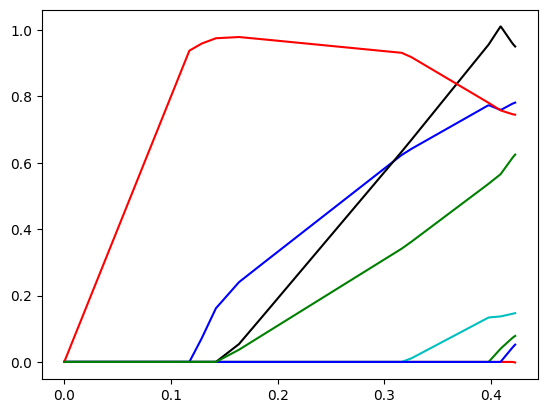

In [26]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

sd_orig  [2.17691972 1.76732586 2.51874218 3.63478133 0.96738236 3.1149856
 1.78160822 3.68926797]


 66%|██████▌   | 132/200 [00:15<00:14,  4.60it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:37<00:00,  5.37it/s]

you are printing coeff in function of l1 norm


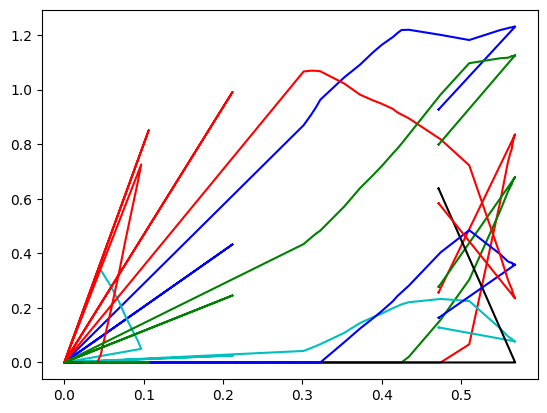

In [27]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig ", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain = AdversarialTraining(X_orig, y, S_inv_orig, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(300, 8)
std_orig: 
 [2.17691972 1.76732586 2.51874218 3.63478133 0.96738236 3.1149856
 1.78160822 3.68926797]
std rf
  [2.0690049  1.74010708 2.32221719 3.39866602 0.91757241 3.06690855
 1.69388984 3.75998487]


 58%|█████▊    | 117/200 [00:02<00:04, 19.25it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:28<00:00,  7.01it/s]

you are printing coeff in function of l1 norm


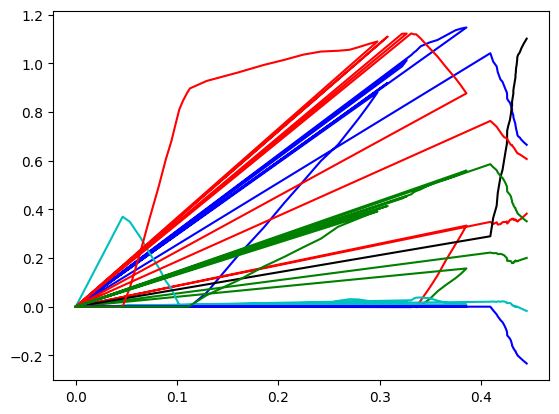

In [28]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


std_orig: 
 [2.17691972 1.76732586 2.51874218 3.63478133 0.96738236 3.1149856
 1.78160822 3.68926797]
std  br
  [2.10051196 1.70222281 2.43729539 3.57009199 0.93237685 2.96761712
 1.6984734  3.62081523]


 26%|██▌       | 51/200 [00:07<01:11,  2.08it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [01:05<00:00,  3.07it/s]

you are printing coeff in function of l1 norm


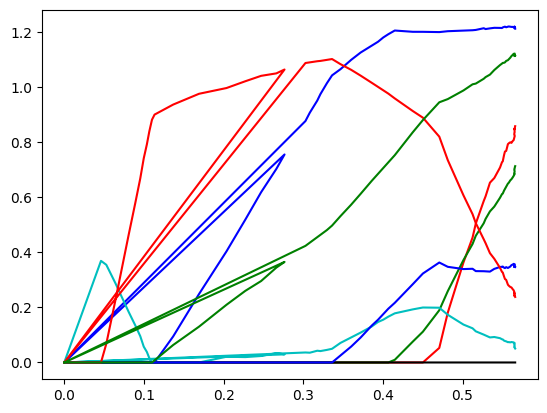

In [29]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

[1.81749735 1.52619667 2.09291042 3.19402541 0.83504116 2.75012368
 1.57215159 3.23459577]


 72%|███████▏  | 143/200 [00:04<00:06,  8.26it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:23<00:00,  8.46it/s]

you are printing coeff in function of l1 norm


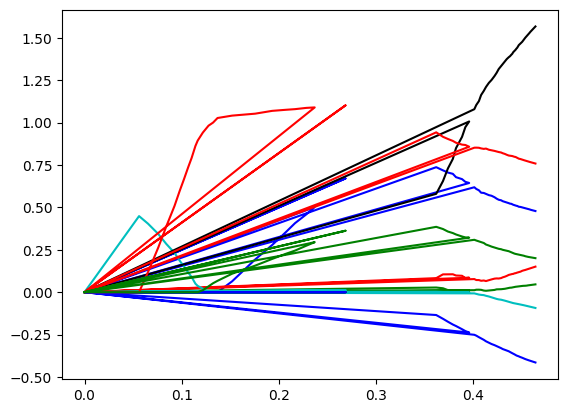

In [30]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


means  [ 0.97298399  3.04465099  1.84806985  4.11254741  1.79415141  1.83732697
  4.22126394 -0.9066767 ]
delta  0.24916666666666668
nbr obs 300
eig cov  [0.37976804 0.50116315 0.85922008 1.0996036  1.23297822 1.42096348
 1.96605605 2.94936539]
300 8
sd ellp [1.81873192 1.53081093 2.09674413 3.1989703  0.83795363 2.75286765
 1.58197453 3.23751044]


100%|██████████| 200/200 [00:17<00:00, 11.37it/s]

you are printing coeff in function of l1 norm


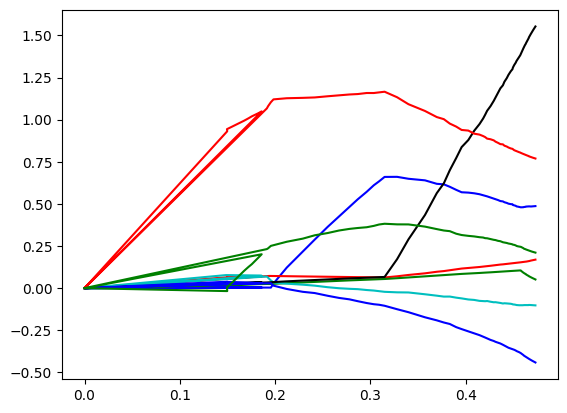

In [31]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/d - 1/(d**2)) * np.diag(np.diag(S_ellp)) + 1/(d**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


In [ ]:
# mi bayesian ridge

number_multiple_imputed_datasets = 5
X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)

fig, ax = plt.subplots(num='advtrain_linf_mi')
linfadvtrain_mi = AdversarialTraining(X_mi, yy, S_inv_mi, p=np.inf)
estimator_mi = lambda X, y, a:  linfadvtrain_mi(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mi  = get_path(X_mi, yy, estimator_mi, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mi, ax)





std_orig: 
 [2.17691972 1.76732586 2.51874218 3.63478133 0.96738236 3.1149856
 1.78160822 3.68926797]
sd_mi
  [2.19559059 1.76069076 2.51199541 3.65834105 0.9761691  3.09642754
 1.7865022  3.70071421]


 75%|███████▌  | 150/200 [00:36<02:16,  2.72s/it]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 81%|████████  | 162/200 [01:14<01:50,  2.90s/it]

In [ ]:
Observations:

-) If the data are np.random.randn(), all the graphs looks similar